In [1]:
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.layers import LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.dates import DateFormatter
import pandas
import keras
import numpy as np
import matplotlib.pyplot as plt
#!pip install mock
import mock
import datetime
import matplotlib.dates as mdates
import tensorflow as tf
from scipy.optimize import minimize 

/Users/apple/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def read_dataset(filename, columns, scaler): 
    dataframe = pandas.read_csv(filename, sep=',', usecols=columns, engine='python')
    #dataframe = pandas.read_csv(filename, sep='\t',usecols=columns, engine='python')
    dataset = dataframe.values
    return dataset

In [3]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [4]:
def save_model(filename, model):
    fn_json = filename + '.json'
    fn_h5 = filename + '.h5'
    model_json = model.to_json()
    with open(fn_json, 'w+') as json_file:
        json_file.write(model_json)
    model.save_weights(fn_h5)

In [5]:
def hard_tanh (x):
    return tf.minimum(tf.maximum(x, -1.), 1.)

In [6]:

old_get = keras.activations.get
def patch_get(x):
    return hard_tanh if x == 'hard_tanh' else old_get(x)
@mock.patch('keras.activations.get', patch_get)
def load_model(filename):
    fn_json = filename + '.json'
    fn_h5 = filename + '.h5'
    json_file = open(fn_json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json, custom_objects={'hard_tanh': hard_tanh})
    loaded_model.load_weights(fn_h5)
    print('Model is loaded')
    return loaded_model

def noisy_input(x, c=0.05):
    noise = np.random.normal(loc=0.0, scale=1.0, size=np.shape(x))
    output = x + c*noise
    return output

In [7]:
def model_lstm_train(units, trainX, trainY, epochs, batch_size, validation_split):
    model = Sequential()
    model.add(LSTM(units, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=2, validation_split=validation_split)
    save_model('LSTM_model', model)
    return model

In [8]:
def model_gru_train(units, trainX, trainY, epochs, batch_size, validation_split):
    model = Sequential()
    model.add(GRU(units, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=2, validation_split=validation_split)
    save_model('GRU_model',model)
    return model

In [9]:
def flow_predict(x_data, x_true, model, model_type):
    dataPredict = model.predict(x_data)
    scoreMSE = mean_squared_error(x_true, dataPredict[:,0])
    scoreMAE = mean_absolute_error(x_true, dataPredict[:,0])
    print(model_type + 'Test score: %.2lf MSE %.2lf MAE' %(scoreMSE, scoreMAE))
    return dataPredict, x_true, scoreMSE, scoreMAE

In [10]:
def flow_plot(x_pred, x_true, start, len):
    truePlot = np.transpose(x_true)
    truePlot = truePlot[start:len]
    predPlot = x_pred[start:len]
    plt.plot(truePlot, label='True Plot')
    plt.plot(predPlot, label='Predicted Plot')
    plt.legend()
    plt.show()

In [11]:
#Scaler for data
scaler = MinMaxScaler(feature_range=(-1, 1))

time_step = 21 
batch_size = 40 
units = 32
validation_split = 0.2
asset_num = 3


In [12]:
# merge the rest of them togehter
predictedTestLstmAll=[]
testLstmAll=[]
predictedTestGruAll=[]
testGruAll=[]

for j in range(asset_num):#iterate over each asset
    train = read_dataset('coins_weight_train.csv',[j],scaler)
    test = read_dataset('coins_weight_test.csv', [j] ,scaler)
    trainX, trainY = create_dataset(train, time_step)
    testX, testY = create_dataset(test, time_step)
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    #For optimal training, search for the right number of iterations.
    start = 20
    end = 40
    step = 20
    n = (int)((end - start)/step)
    data_train_mse = np.zeros((2, n))#2 stands for two model
    data_test_mse = np.zeros((2, n))
    data_train_mae = np.zeros((2, n))
    data_test_mae = np.zeros((2, n))
    
    for epochs in range(start, end, step):

        i = (int)((epochs - start)/step)
        print('Number of epochs: %d' %(epochs))
        modelLstm = model_lstm_train(units, trainX, trainY, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
        modelGru = model_gru_train(units, trainX, trainY, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
        predictedTrainLstm, trainLstm, data_train_mse[0,i], data_train_mae[0,i] = flow_predict(trainX, trainY, modelLstm, 'LSTM Training ')
        predictedTestLstm, testLstm, data_test_mse[0,i], data_test_mae[0,i] = flow_predict(testX, testY, modelLstm, 'LSTM Testing ')
        predictedTrainGru, trainGru, data_train_mse[1,i], data_train_mae[1,i] = flow_predict(trainX, trainY, modelGru, 'GRU Training ')
        predictedTestGru, testGru, data_test_mse[1,i], data_test_mae[1,i] = flow_predict(testX, testY, modelGru, 'GRU Testing ')
    else:
        print('Done')
        df_mse = pandas.DataFrame(data_test_mse)
        df_mae = pandas.DataFrame(data_test_mae)
        df_mse.to_csv('mse.csv')
        df_mae.to_csv('mae.csv')
        
    modelLstm = load_model('LSTM_model')
    modelGru = load_model('GRU_model')
    i=0
    predictedTestLstm, testLstm, data_test_mse[0,i], data_test_mae[0,i] = flow_predict(testX, testY, modelLstm, 'LSTM Testing ')
    predictedTestGru, testGru, data_test_mse[1,i], data_test_mae[1,i] = flow_predict(testX, testY, modelGru, 'GRU Testing ')
    predictedTestLstmAll.append(predictedTestLstm)
    testLstmAll.append(testLstm)
    predictedTestGruAll.append(predictedTestGru)
    testGruAll.append(testGru)  

Number of epochs: 20
Train on 558 samples, validate on 140 samples
Epoch 1/20
 - 2s - loss: 0.3550 - val_loss: 0.2254
Epoch 2/20
 - 0s - loss: 0.2482 - val_loss: 0.2188
Epoch 3/20
 - 0s - loss: 0.2452 - val_loss: 0.2212
Epoch 4/20
 - 0s - loss: 0.2422 - val_loss: 0.2152
Epoch 5/20
 - 0s - loss: 0.2423 - val_loss: 0.2155
Epoch 6/20
 - 0s - loss: 0.2409 - val_loss: 0.2142
Epoch 7/20
 - 0s - loss: 0.2405 - val_loss: 0.2141
Epoch 8/20
 - 0s - loss: 0.2395 - val_loss: 0.2149
Epoch 9/20
 - 0s - loss: 0.2392 - val_loss: 0.2129
Epoch 10/20
 - 0s - loss: 0.2386 - val_loss: 0.2133
Epoch 11/20
 - 0s - loss: 0.2385 - val_loss: 0.2127
Epoch 12/20
 - 0s - loss: 0.2377 - val_loss: 0.2131
Epoch 13/20
 - 0s - loss: 0.2375 - val_loss: 0.2125
Epoch 14/20
 - 0s - loss: 0.2372 - val_loss: 0.2128
Epoch 15/20
 - 0s - loss: 0.2373 - val_loss: 0.2128
Epoch 16/20
 - 0s - loss: 0.2398 - val_loss: 0.2118
Epoch 17/20
 - 0s - loss: 0.2400 - val_loss: 0.2170
Epoch 18/20
 - 0s - loss: 0.2392 - val_loss: 0.2117
Epoch 

698


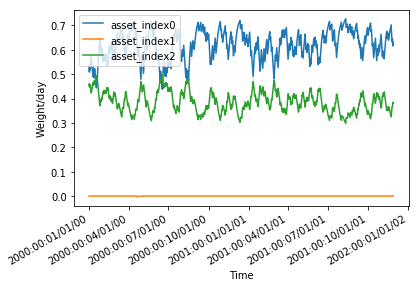

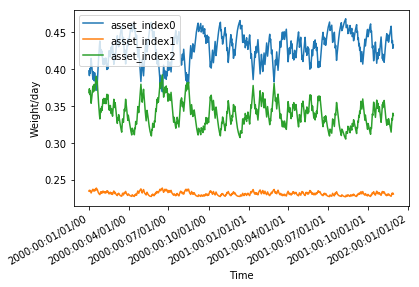

In [13]:
start=0
true = np.transpose(testLstmAll[0])
end=true.shape[0]
print(end)
timeAxis = [datetime.datetime(year=2000, month=1, day=1, hour=0, minute=0) + datetime.timedelta(days=i) for i in range(0,end)]
fig, ax = plt.subplots(1)


trueAll=np.zeros((end,asset_num))
pred1All=np.zeros((end,asset_num))
for j in range(asset_num):
    true = np.transpose(testLstmAll[j])
    true = true[start:start+end]
    pred1 = predictedTestLstmAll[j]
    pred1=pred1[start:start+end]
    trueAll[:,j]=true
    pred1All[:,j]=np.reshape(pred1,end)   
    ax.plot(timeAxis, pred1, label='asset_index'+str(j))
fig.autofmt_xdate()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xlabel('Time')
plt.ylabel('Weight/day')
plt.legend()
plt.show()
plt.savefig("beforeSoftMax.png")
    
adj_pred1All=np.zeros((end,asset_num))
        
for i in range(end):
    adj_pred1=np.exp(pred1All[i,:])/sum(np.exp(pred1All[i,:]))
    adj_pred1All[i,:]=np.reshape(adj_pred1,3)     

fig, ax = plt.subplots(1)
for j in range(asset_num):
    true = np.transpose(testLstmAll[j])
    true = true[start:start+end]
    pred1 = adj_pred1All[:,j]
    pred1=pred1[start:start+end]
    ax.plot(timeAxis, pred1, label='asset_index'+str(j))
    
fig.autofmt_xdate()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xlabel('Time')
plt.ylabel('Weight/day')
plt.legend()
plt.show()
plt.savefig("afterSoftMax.png")
    
